In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
from src.visualization.vis_data import *
import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

Loading BokehJS ...

# Traffice 2020

In [36]:
t_folder = '../data/traffic/'
t_files = glob(t_folder + '*.csv')

In [42]:
trf = pd.read_csv(t_files[0])
trf = trf.iloc[:,1:]
trf.columns = ['date', 'max', 'mean']
 # extract months and date 
trf['month'] = trf['date'].str.extract('(\D+)').iloc[:,0]
trf['day'] = trf['date'].str.extract('(\d+)').iloc[:,0]
month_list = s.unique().tolist()

,date,max,mean
0,1มกราคม,3.7,2.1
1,2มกราคม,5.5,2.7


In [60]:
month_dict = {}
for i, m in enumerate(month_list):
    i += 1
    if len(str(i))==1:
        month_dict[m] = '-0'+str(i)
    else:
        month_dict[m] = str(i)
        
print(month_dict)

{'มกราคม': '-01', 'กุมภาพันธ์': '-02', 'มีนาคม': '-03', 'เมษายน': '-04', 'พฤษภาคม': '-05', 'มิถุนายน': '-06', 'กรกฎาคม': '-07', 'สิงหาคม': '-08'}


In [78]:
# change month to number 
trf['month'] = trf['month'].replace(month_dict)

# combine month, date into one strings
date_list = []
for i, row in trf.iterrows():
    if len(row['day']) == 1:
        day = '-0' + row['day']
    else:
        day = '-' + row['day']
    new_date = '2020'+row['month'] + day
    date_list.append(new_date)
    
trf['date'] = pd.to_datetime(date_list)
trf = trf[['date','max','mean']]

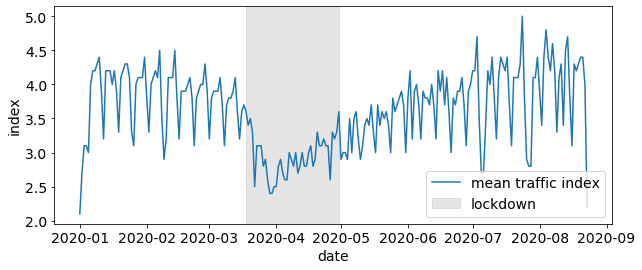

In [103]:
_, ax = plt.subplots(figsize=(10,4))
ax.plot(trf['date'], trf['mean'], label='mean traffic index')


#ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
ax.axvspan(datetime(2020, 3, 18), datetime(2020, 4, 30), color='gray', alpha=0.2, label='lockdown' )
ax.set_xlabel('date')
ax.set_ylabel('index')
ax.legend(loc='lower right')

# BKK Data 

In [110]:
# start building dataset from scratch only perform this when new data files are added 
dataset = Dataset('Bangkok')
dataset.build_all_data( build_fire=True, build_holiday = True)

save file ../data/bangkok/02t.csv
save file ../data/bangkok/03t.csv
save file ../data/bangkok/05t.csv
save file ../data/bangkok/11t.csv
save file ../data/bangkok/12t.csv
save file ../data/bangkok/50t.csv
save file ../data/bangkok/52t.csv
save file ../data/bangkok/53t.csv
save file ../data/bangkok/59t.csv
save file ../data/bangkok/61t.csv
Averaging data from 11 stations
Loading all hotspots data. This might take sometimes
before drop (3168630, 18)
after drop (3064842, 10)


In [3]:
# reinit the data and load saved process data 
dataset = Dataset('Bangkok')
dataset.load_()
# merge pollution data with other data except fire
dataset.feature_no_fire()

data no fire has shape (52770, 14)


Index(['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2'], dtype='object')


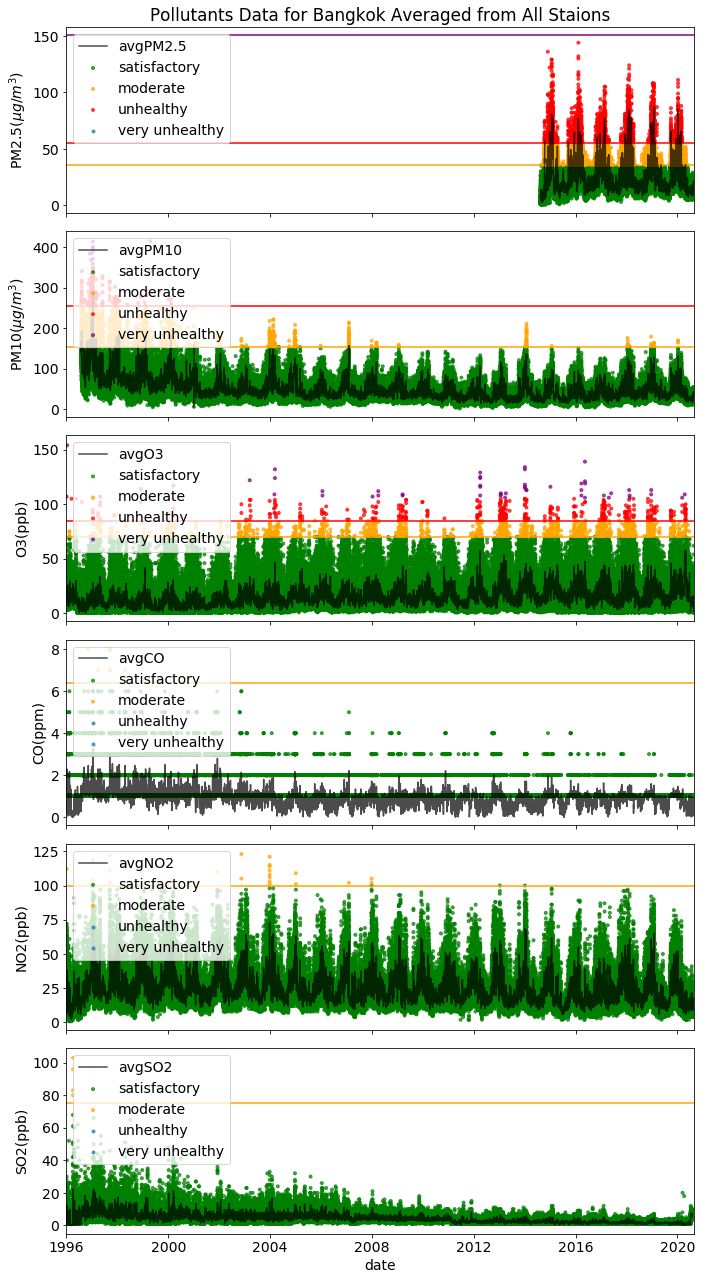

In [172]:
# plot the raw data
plot_all_pollutions(dataset.poll_df, city_name=dataset.city_name)

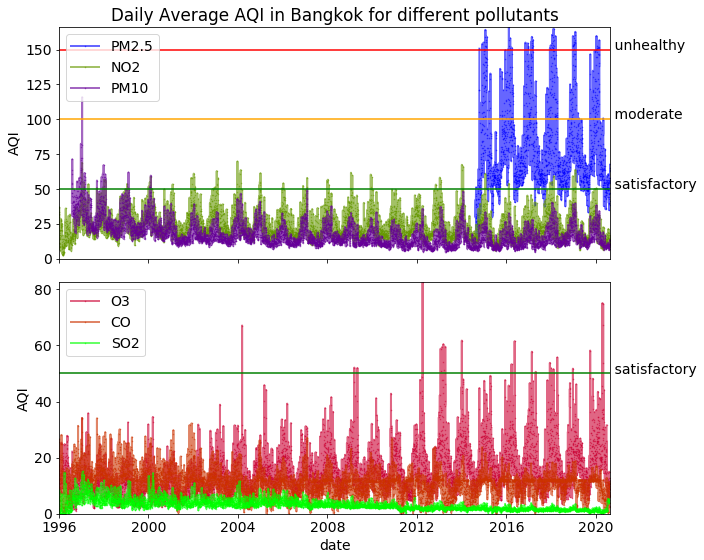

In [173]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

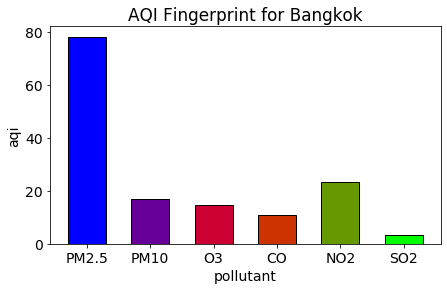

In [174]:
plot_chem_print(poll_to_aqi(dataset.poll_df.copy(), dataset.roll_dict).mean(axis=0), dataset.city_name, filename=dataset.report_folder + 'fingerprint.png')

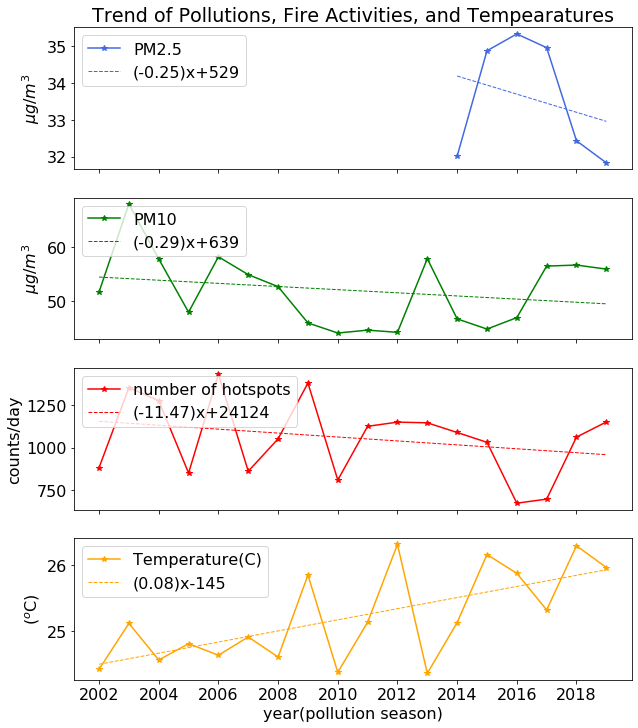

In [331]:
ax, year_avg = plot_yearly_ln(dataset, filename=dataset.report_folder + 'compare_ln_trends.png')

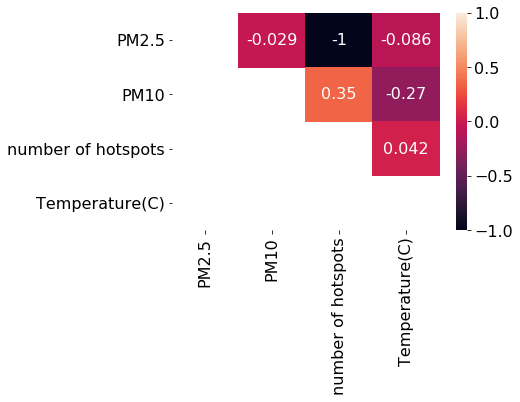

In [332]:
plot_corr(year_avg, figsize=(6,4))

aqi 100 in  11-05 to 03-28


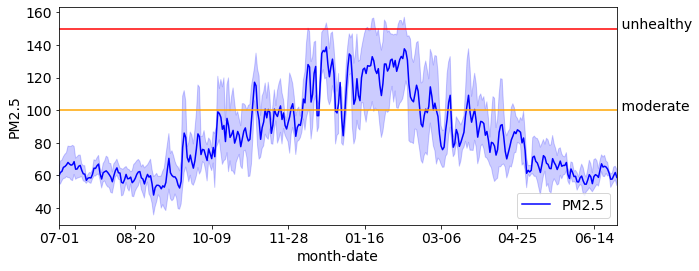

In [335]:
plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25.png')

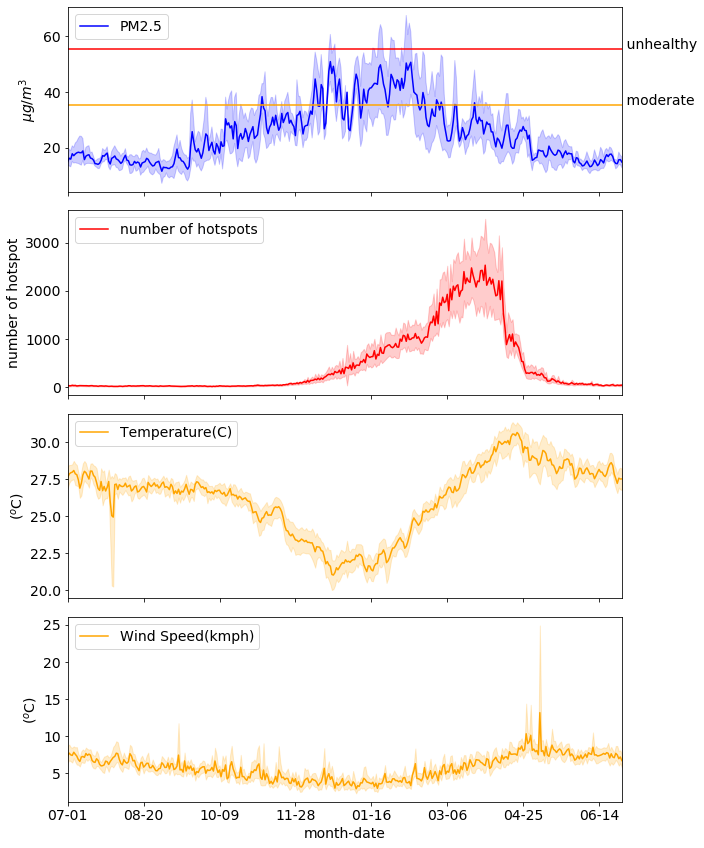

In [346]:
compare_seson_avg(dataset, agg='mean')
ax[3].set_ylim([0,15])

plt.savefig(dataset.report_folder + 'fire_PM25_season.png')

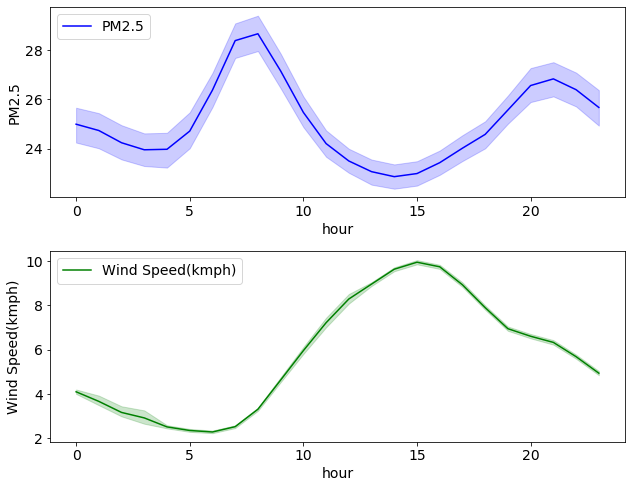

In [19]:
_, ax = plt.subplots(2, 1, figsize=(9, 7))
plot_hour_avg(dataset.poll_df.copy(), 'PM2.5', ax[0],  color='blue')
plot_hour_avg(dataset.wea.copy(), 'Wind Speed(kmph)', ax[1],  color='green')
plt.tight_layout()

# Map

In [4]:
dataset.city_info

x = merc_x(dataset.city_info['Longitude'])
y = merc_y(dataset.city_info['Latitude'])
#stepx = 2E5

stepx = 1E6
stepy = stepx

In [13]:
# select fire data 
fire = dataset.fire
i = 0
month_list = ['2019-03','2019-04']
month = month_list[i]
color = 'red'
fire1 = fire.loc[month:month_list[i+1]]

month_list = ['2018-12','2019-01']
month = month_list[i]
fire2 = fire.loc[month:month_list[i+1]]

In [14]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-0.5*stepx,x+0.5*stepx), y_range=(y-stepy*0.1, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = dataset.city_name)
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

# add city center
p.scatter(x,y,color='red',line_color='black',size=10, legend_label=dataset.city_name)

# plot hotspots at the begining and end of winter season

p.scatter(fire1['long_km']*1000,fire1['lat_km']*1000,color='red',size=1, alpha=0.5,legend_label='fire in Mar 2019')

p.scatter(fire2['long_km']*1000,fire2['lat_km']*1000,color='blue',size=1, alpha=0.5, legend_label='fire in Dec 2018')

#add circles
labels = ['0-100km','100-200km','200-400km','400-600km']

rs = [100, 200, 400, 600]
rs.reverse()
colors = get_color(color_length=len(labels),cmap=cm.jet)
for i, (r, label, color) in enumerate(zip(rs, labels, colors)):
    if i ==3 or i ==2:
        alpha=0.4
    else:
        alpha=0.2
        
    xy = get_circle(x,y,r=r*1E3)
    p.patch(xy[0,:],xy[1,:],alpha=alpha,line_width=2,line_color='black',color=color, legend_label=label)
    
p.legend.location = "bottom_right"

show(p)

# Train Model

data no fire has shape (52731, 21)
use default fire feature
=================optimize 1: find the best RF model=================
{'n_estimators': 180, 'min_samples_split': 50, 'min_samples_leaf': 23, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False} 0.27101123178516395
optimize 1 score {'val_r2_score': 0.3101758778630781, 'val_mean_squared_error': 140.62754618537562, 'val_mean_absolute_error': 8.828853893773758}
=================optimize 2: remove unncessary columns=================
old cols length 25
drop time_of_day_[9, 12)
drop time_of_day_[15, 18)
drop time_of_day_[6, 9)
drop fire_100_200
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day_[0, 3)', 'time_of_day_[3, 6)', 'time_of_day_[12, 15)', 'time_of_day_[18, 21)', 'time_of_day_[21, 24)', 'fire_0_100', 'fire_200_400', 'fire_400_800', 'fire_800_1000']
score after dropping columns {'r2_s

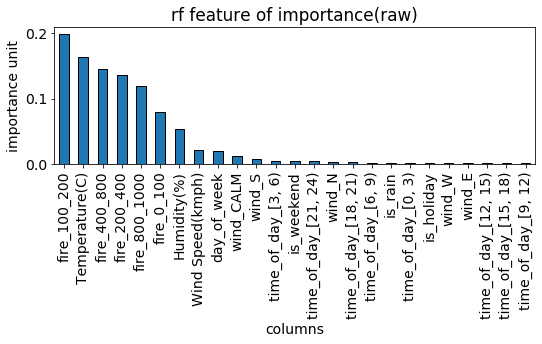

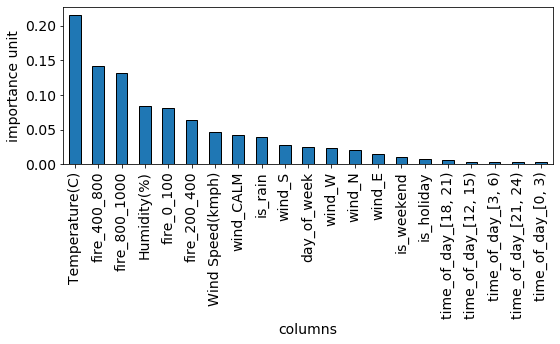

In [8]:
dataset, model, poll_meta = train_city_s1(city= 'Bangkok', pollutant='PM2.5')

In [9]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Bangkok', pollutant='PM2.5', split_list=[0.8, 0.2])

data no fire has shape (52762, 21)
raw model performance {'test_r2_score': 0.4542498785184952, 'test_mean_squared_error': 105.04173082228195, 'test_mean_absolute_error': 7.638214197932823}
daily avg training error {'avg_trn_r2_score': 0.8985223393551013, 'avg_trn_mean_squared_error': 19.241718681719895, 'avg_trn_mean_absolute_error': 3.1073030813220317}
daily avg test error {'avg_test_r2_score': 0.5310800984925479, 'avg_test_mean_squared_error': 74.32586368022162, 'avg_test_mean_absolute_error': 6.4134822170156305}


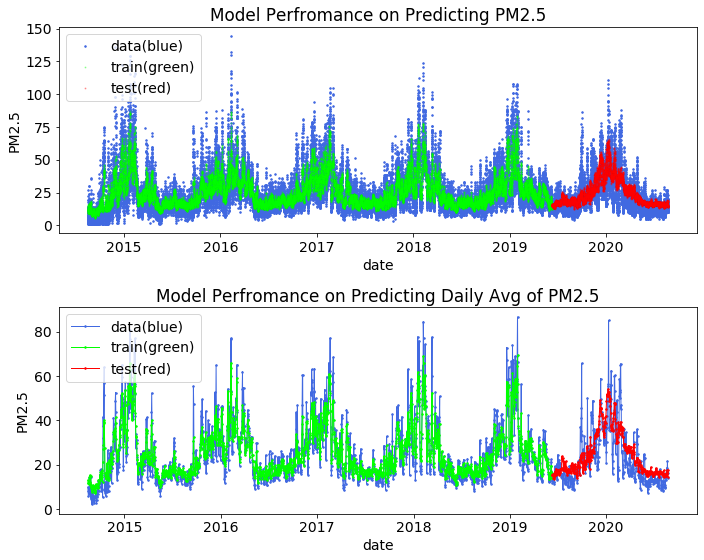

In [10]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.8, 0.2], xlim=[], to_save=True)

data no fire has shape (52783, 21)
use default fire feature
=================optimize 1: find the best RF model=================
{'n_estimators': 140, 'min_samples_split': 50, 'min_samples_leaf': 25, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True} 0.26360985643197987
optimize 1 score {'val_r2_score': 0.33113479290792536, 'val_mean_squared_error': 136.72001415900422, 'val_mean_absolute_error': 8.752519952985194}
=================optimize 2: remove unncessary columns=================
old cols length 26
drop time_of_day_[21, 24)
drop fire_100_200
use columns ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day_[0, 3)', 'time_of_day_[3, 6)', 'time_of_day_[6, 9)', 'time_of_day_[9, 12)', 'time_of_day_[12, 15)', 'time_of_day_[15, 18)', 'time_of_day_[18, 21)', 'fire_0_100', 'fire_200_400', 'fire_400_600', 'fire_600_800', 'fire_800_1000']
score after dropping co

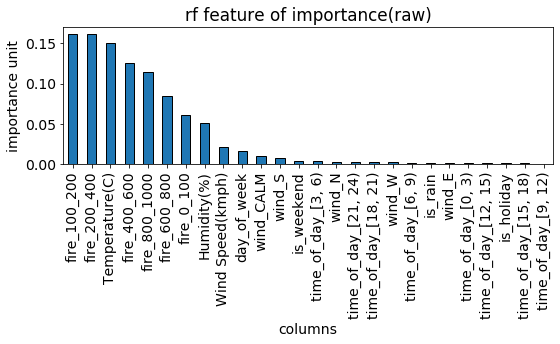

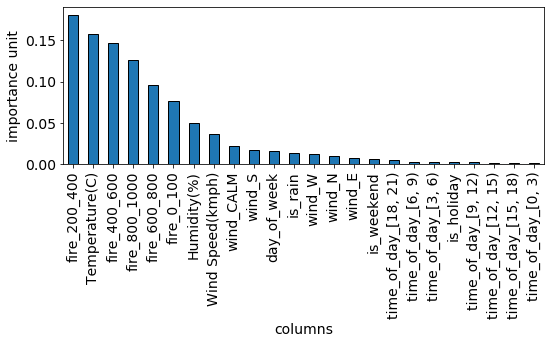

In [18]:
dataset, model, poll_meta = train_city_s1(city= 'Bangkok', pollutant='PM2.5')

In [19]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Bangkok', pollutant='PM2.5', split_list=[0.8, 0.2])

data no fire has shape (52801, 21)
raw model performance {'test_r2_score': 0.44643308046105057, 'test_mean_squared_error': 106.50649183085086, 'test_mean_absolute_error': 7.73752343300369}
daily avg training error {'avg_trn_r2_score': 0.8521492072108316, 'avg_trn_mean_squared_error': 28.18101878093847, 'avg_trn_mean_absolute_error': 3.81684957280046}
daily avg test error {'avg_test_r2_score': 0.5263525346044393, 'avg_test_mean_squared_error': 75.09394652925938, 'avg_test_mean_absolute_error': 6.475809606518423}


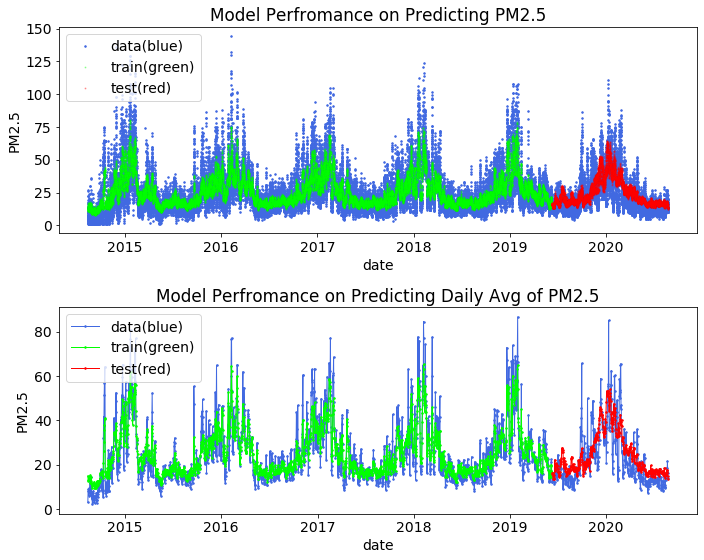

In [20]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.8, 0.2], xlim=[], to_save=True)